In [1]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.linalg import block_diag
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from src.FirstRoundTest import Forecast

In [2]:
csv_file_path = "./tutorial.csv"
df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])
print(products)

raw = {}

for product in products:
    raw[product] = df[df['product'] == product]

['AMETHYSTS' 'STARFRUIT']


# Linear regression

Training R^2 score: 0.9975278218000861
Validation R^2 score: 0.9972491755823473
Test R^2 score: 0.9975194913906088
Coefficients: [0.5916807634560216, 0.2327306356720495, 0.115885324988802, 0.05940967344182543]
Intercept: 1.4328896847300712
--------------------
Training MSE: 0.49691148898620463
Validation MSE: 0.5469122731039175
Test MSE: 0.5071385854108471


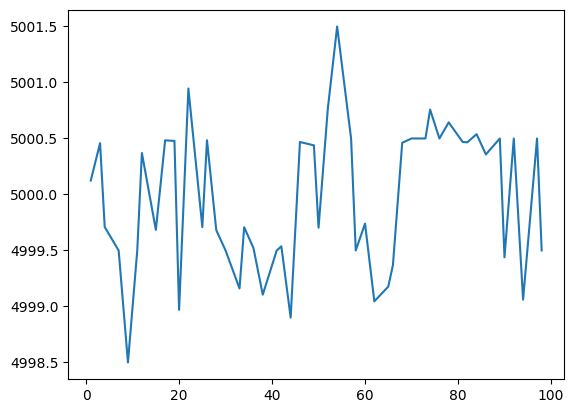

In [107]:
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.metrics import mean_squared_error

# Prepare the data
data_series = raw[products[1]]['mid_price']
raw[products[1]] = raw[products[1]].fillna(0)

weighted_data_series = ((raw[products[1]]['ask_price_1'] * raw[products[1]]['ask_volume_1'] 
                        + raw[products[1]]['bid_price_1'] * raw[products[1]]['bid_volume_1']
                        + raw[products[1]]['ask_price_2'] * raw[products[1]]['ask_volume_2']
                        + raw[products[1]]['bid_price_2'] * raw[products[1]]['bid_volume_2']
                        + raw[products[1]]['ask_price_3'] * raw[products[1]]['ask_volume_3']
                        + raw[products[1]]['bid_price_3'] * raw[products[1]]['bid_volume_3']
                         ) 
                        / (
                        raw[products[1]]['ask_volume_1'] + raw[products[1]]['bid_volume_1']
                        + raw[products[1]]['ask_volume_2'] + raw[products[1]]['bid_volume_2']
                        + raw[products[1]]['ask_volume_3'] + raw[products[1]]['bid_volume_3']
                        )
                        ) 


total_volume_bid = raw[products[1]]['bid_volume_1'] + raw[products[1]]['bid_volume_2'] + raw[products[1]]['bid_volume_3']
total_volume_ask = raw[products[1]]['ask_volume_1'] + raw[products[1]]['ask_volume_2'] + raw[products[1]]['ask_volume_3']

bb_price = (raw[products[1]]['bid_price_1'] * raw[products[1]]['bid_volume_1']
                        + raw[products[1]]['bid_price_2'] * raw[products[1]]['bid_volume_2']
                        + raw[products[1]]['bid_price_3'] * raw[products[1]]['bid_volume_3']
                         ) / total_volume_bid
ba_price = (raw[products[1]]['ask_price_1'] * raw[products[1]]['ask_volume_1']
                        + raw[products[1]]['ask_price_2'] * raw[products[1]]['ask_volume_2']
                        + raw[products[1]]['ask_price_3'] * raw[products[1]]['ask_volume_3']
                         ) / total_volume_ask

micro_price_df = (bb_price * total_volume_ask + ba_price * total_volume_bid) / (total_volume_bid + total_volume_ask)

X = []
y = []
mid_price = []
micro_price = []
weighted_data = []

for price in data_series:
    mid_price.append(int(price))
    
for weighted_data_s in weighted_data_series:
    weighted_data.append(int(weighted_data_s))

for x in micro_price_df:
    micro_price.append(int(x))
    
    
SR = micro_price
# SR = weighted_data
for i in range(10, len(SR)):
    X.append(SR[i - 4:i])  # Use the previous 4 elements as predictors
    y.append(SR[i])

X = np.array(X[2:])
y = np.array(y[2:])

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Evaluate the model
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

print("Training R^2 score:", train_score)
print("Validation R^2 score:", val_score)
print("Test R^2 score:", test_score)
print("Coefficients:", list(reversed(model.coef_)))
print("Intercept:", model.intercept_)

#compute mse
train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("--------------------")

print("Training MSE:", train_mse)
print("Validation MSE:", val_mse)
print("Test MSE:", test_mse)

plt.plot(micro_price_df[:50])
# plt.plot(SR)
plt.show()


# ARIMA

In [70]:
SR = np.diff(SR)

In [78]:
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# plot_acf(SR)
# plot_pacf(SR)
model = ARIMA(SR, order=(1, 0, 3))  # ARIMA(4, 0, 1) with 4 lagged observations
results = model.fit()
print(list(results.arparams))
print(list(results.maparams))

# check accuracy
predictions = results.predict(start=0, end=len(SR) - 1)
mse = mean_squared_error(SR, predictions)
print("MSE:", mse)

# intercept
print("Intercept:", results.params[0])

mid_price = np.array(mid_price)


[0.8857434267914153]
[-1.3465327628374832, 0.38377439117733786, 0.007051665349688285]
MSE: 0.5038198703965315
Intercept: -0.02396766126833186


Stanford MSE: 2.7551533433886375
My MSE: 0.45098039215686275


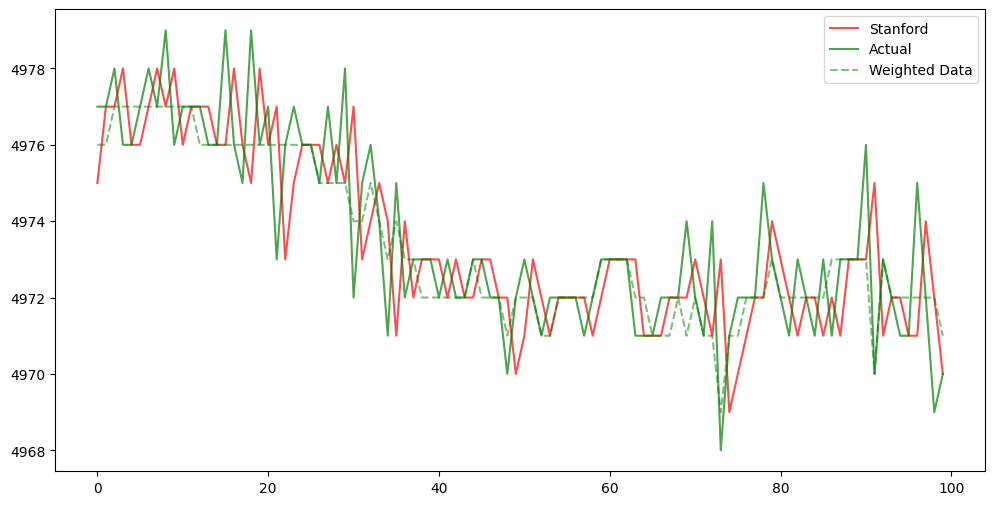

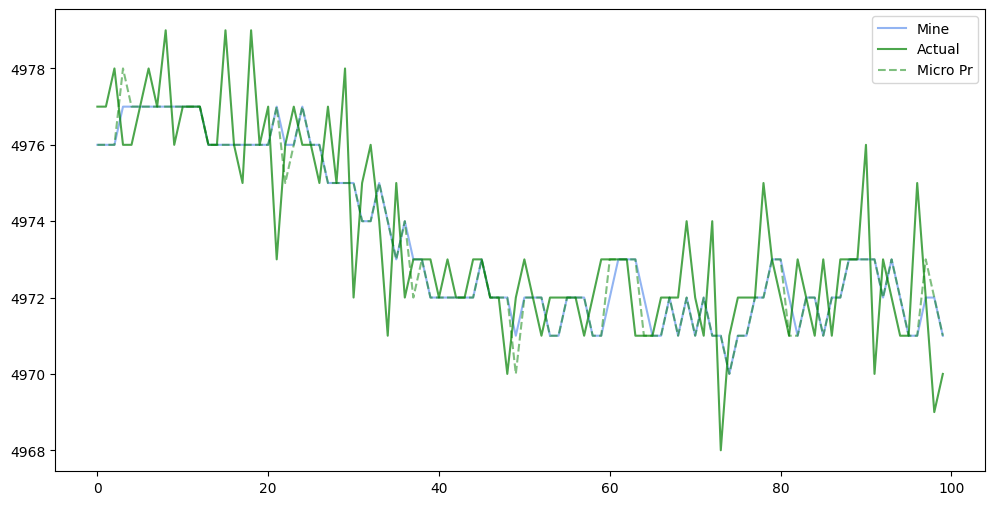

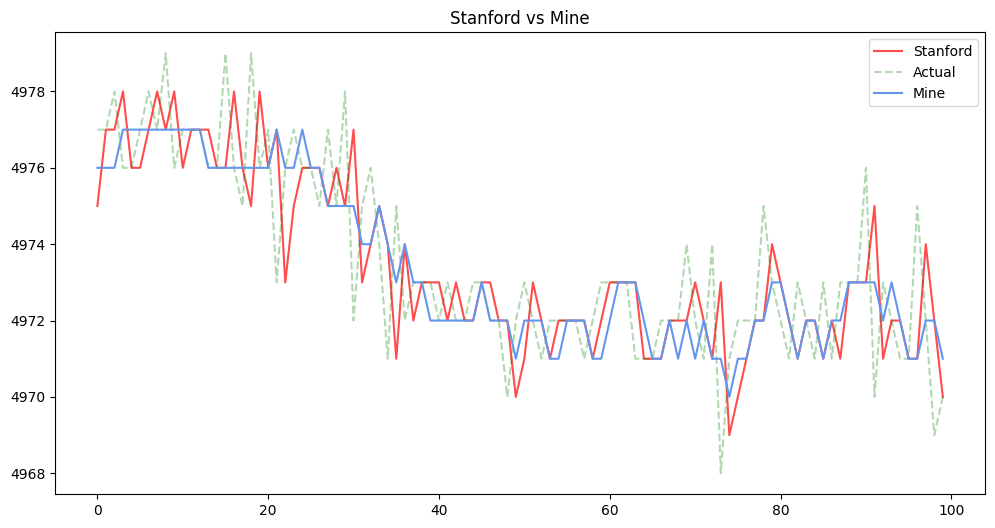

In [110]:
weighted_actual = []
my_predictions = []
micro_pr_array = []
stanford_predictions = []
actual = []

stanford_coef      = [-0.01869561, 0.0455032, 0.16316049, 0.8090892]
# [0.8090892, 0.16316049, 0.0455032, -0.01869561]
stanford_intercept = 4.481696494462085
    
forecast_starfruit = Forecast(
        ar_coeffs=[0.5916807634560216, 0.2327306356720495, 0.115885324988802, 0.05940967344182543],
        ma_coeffs=[],
        drift=1.4328896847300712,
        forecast_return=False
    )
    

for i in range(0, 10):
    price = int(mid_price[i])
    weighted_price = int(weighted_data[i])
    micro_pr = int(micro_price[i])
    forecast_starfruit.update(micro_pr)

for i in range(10, len(mid_price)):
    price = int(mid_price[i])
    weighted_price = int(weighted_data[i])
    micro_pr = int(micro_price[i])
    
    stanford_predictions.append(int(round(np.dot(stanford_coef, mid_price[i - 3:i + 1]) + stanford_intercept)))
    
    forecast_starfruit.update(micro_pr)
    
    forecasted_pr   = forecast_starfruit.forecast(micro_pr)
    
    my_predictions.append(forecasted_pr)
    weighted_actual.append(weighted_price)
    actual.append(price)
    micro_pr_array.append(micro_pr)

# predictions are shifted by one
weighted_actual = weighted_actual[1:]
actual = actual[1:]

stanford_predictions = stanford_predictions[:-1]
my_predictions = my_predictions[:-1]

# Stanford MSE: 2.7073016953488045
my_mse = mean_squared_error(weighted_actual, my_predictions)
stanford_mse = mean_squared_error(actual, stanford_predictions)

print("Stanford MSE:", stanford_mse)
print("My MSE:", my_mse)
    
#n = 1260 is interesting    
n = 1200
l = 100
plt.figure(figsize=(12, 6))
plt.plot(stanford_predictions[n:n+l], label='Stanford', color='red', alpha=0.7)
plt.plot(actual[n:n+l], label='Actual', alpha=0.7, color='green')
plt.plot(weighted_actual[n:n+l], label='Weighted Data', alpha=0.5, color='green', linestyle='dashed')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(my_predictions[n:n+l], label='Mine', alpha=0.7, color='cornflowerblue')
plt.plot(actual[n:n+l], label='Actual', alpha=0.7, color='green')
plt.plot(micro_pr_array[n:n+l], label='Micro Pr', alpha=0.5, color='green', linestyle='dashed')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(stanford_predictions[n:n+l], label='Stanford', color='red', alpha=0.7)
plt.plot(actual[n:n+l], label='Actual', alpha=0.3, color='green', linestyle='dashed')
plt.plot(my_predictions[n:n+l], label='Mine', color='cornflowerblue')
plt.title("Stanford vs Mine")
plt.legend()
plt.show()

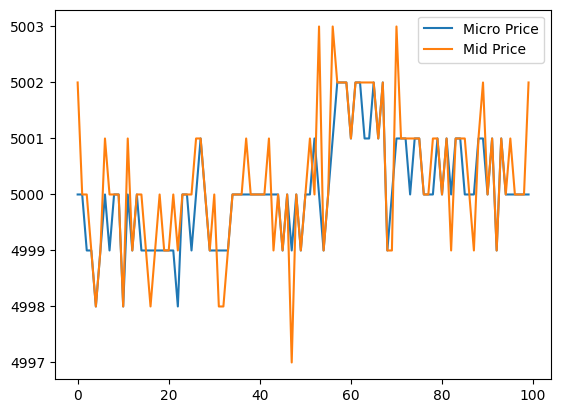

In [111]:
# plot micro prirce vs mid price
plt.plot(micro_price[:100], label='Micro Price')
plt.plot(mid_price[:100], label='Mid Price')
plt.legend()
plt.show()

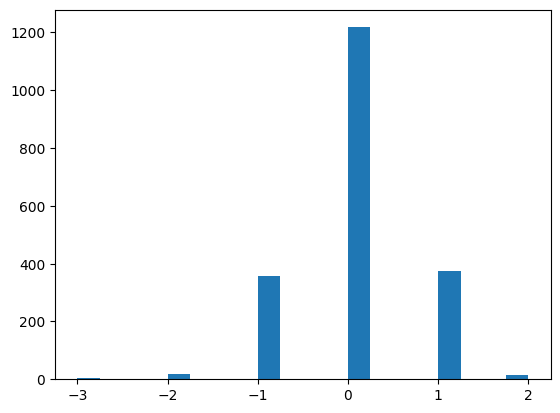

Variance of the residuals: 0.45097407283548707
Mean of the residuals: 0.002513826043237808
Probability of getting a residual of -4 : 0.0
Probability of getting a residual of -3 : 0.0015082956259426848
Probability of getting a residual of -2 : 0.00904977375565611
Probability of getting a residual of -1 : 0.17998994469582705
Probability of getting a residual of 0 : 0.6123680241327301
Probability of getting a residual of 1 : 0.18903971845148315
Probability of getting a residual of 2 : 0.008044243338360985
Probability of getting a residual of 3 : 0.0


In [112]:
weighted_actual = np.array(weighted_actual)
my_predictions = np.array(my_predictions)

diff = weighted_actual - my_predictions
plt.hist(diff, bins=20)
plt.show()

# Calculate the variance of the residuals
print("Variance of the residuals:", np.var(diff))
print("Mean of the residuals:", np.mean(diff))

# Calculate the probability of getting any residuals
for i in range(-4, 4):
    print("Probability of getting a residual of", i, ":", np.mean(diff == i))

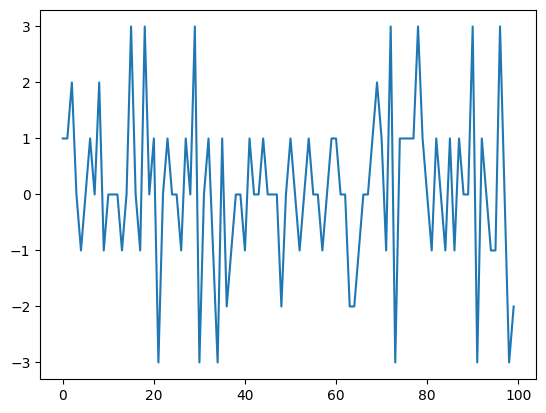

1.9051

In [7]:
diff = actual[n:n+l] - my_predictions[n:n+l]
plt.plot(diff)
plt.show()

np.var(diff)

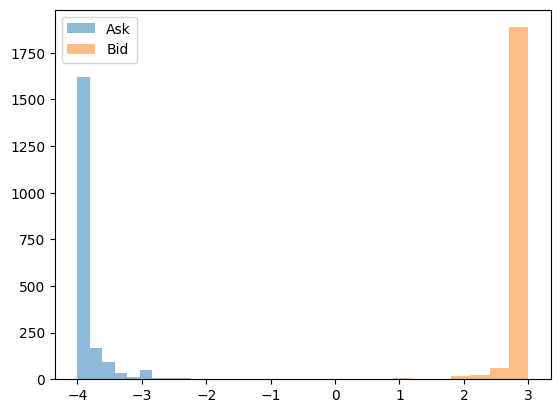

In [8]:
weighted_price = [round(x) for x in weighted_data]

# Calculate weighted ask price
weighted_ask_price = (raw[products[1]]['ask_price_1'] * raw[products[1]]['ask_volume_1'] 
                    + raw[products[1]]['ask_price_2'] * raw[products[1]]['ask_volume_2']
                    + raw[products[1]]['ask_price_3'] * raw[products[1]]['ask_volume_3']
                    ) / (raw[products[1]]['ask_volume_1'] + raw[products[1]]['ask_volume_2'] + raw[products[1]]['ask_volume_3'])

# Calculate weighted bid price
weighted_bid_price = (raw[products[1]]['bid_price_1'] * raw[products[1]]['bid_volume_1'] 
                    + raw[products[1]]['bid_price_2'] * raw[products[1]]['bid_volume_2']
                    + raw[products[1]]['bid_price_3'] * raw[products[1]]['bid_volume_3']
                    ) / (raw[products[1]]['bid_volume_1'] + raw[products[1]]['bid_volume_2'] + raw[products[1]]['bid_volume_3'])

# Calculate difference between weighted mid price and weighted ask price
diff_ask = weighted_price - weighted_ask_price
diff_bid = weighted_price - weighted_bid_price

plt.hist(diff_ask, bins=10, alpha=0.5, label='Ask')
plt.hist(diff_bid, bins=10, alpha=0.5, label='Bid')
plt.legend()

**Conclusions**
- weighted data is almost fully predictable (MSE: 0.006)
- the rest is random noise with mean 0 and variance 1.34
- the difference between weighted mid price and **ask** is around -4
-  the difference between weighted mid price and **bid** is around 3

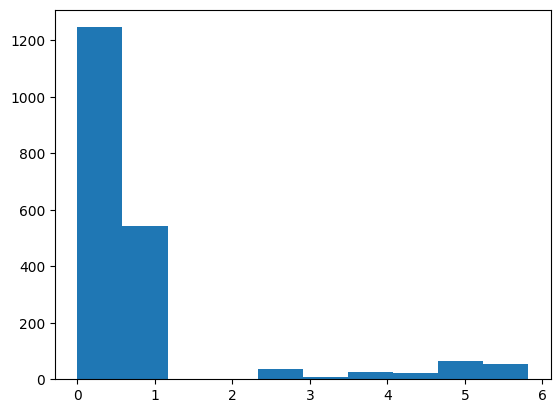

In [9]:
# Plot difference between weighted bid price and best bid price
diff_bid_best = raw[products[1]]['bid_price_1'] - weighted_bid_price
plt.hist(diff_bid_best, bins=10)
plt.show()

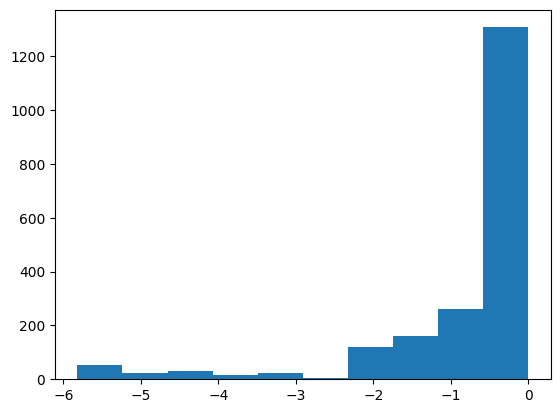

0.654


In [10]:
diff_ask_best = raw[products[1]]['ask_price_1'] - weighted_ask_price
plt.hist(diff_ask_best, bins=10)
plt.show()

diff_ask_best = np.array([int(round(x)) for x in diff_ask_best])

# probability of getting a residual of 0
print(np.mean(diff_ask_best == 0))
# probability of getting a residual of <0 >=-1
# np.mean(diff_ask_best < -1) - np.mean(diff_ask_best < -2)
# np.mean(diff_ask_best < 0)

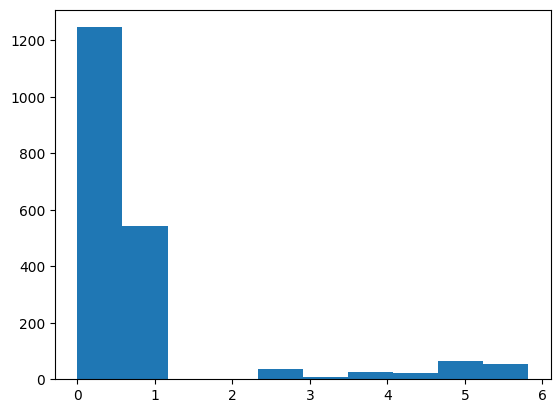

0.063

In [11]:
diff_bid_best = raw[products[1]]['bid_price_1'] - weighted_bid_price
plt.hist(diff_bid_best, bins=10)
plt.show()

# probability of getting a residual of 0
diff_bid_best = np.array([int(round(x)) for x in diff_bid_best])

# probability of getting a residual of <0 >=-1
np.mean(diff_bid_best > 4)
# np.mean(diff_ask_best < 0)

In [12]:
forecasted_error = {}
for i in range(-4, 4):
    forecasted_error[i] = np.mean(diff == i)
# error, probability of getting that error

ask_diff = 4
bid_diff = 3

ask_error = {}
bid_error = {}
for i in range(-6, 1):
    ask_error[int(abs(i))] = np.mean(diff_ask_best == i)
    
for i in range(0, 7):
    bid_error[i] = np.mean(diff_bid_best == i)
    
ask_error   

{6: 0.021, 5: 0.02, 4: 0.0205, 3: 0.013, 2: 0.1355, 1: 0.136, 0: 0.654}

In [13]:
def expected_return_ask(bought_at, weighted_price):
    expected_return = 0
    
    future_bid_price = weighted_price + bid_diff
    
    for i in bid_error.keys():
        expected_return += bid_error[i] * max(0, future_bid_price + i - bought_at)
    
    return expected_return

def expected_return_bid(sold_at, weighted_price):
    expected_return = 0
    
    future_ask_price = weighted_price - ask_diff
    
    for i in ask_error.keys():
        expected_return += ask_error[i] * max(0, sold_at - (future_ask_price - i))
    
    return expected_return

# Calculate the probability 
def get_optimal_prices(forecaster, curr_weighted_pr):
    INF = 1e9
    best_ask = INF
    best_bid = -INF
    
    best_expected_return_ask = 0
    best_expected_return_bid = 0
    
    future_weighted_pr = forecaster.forecast(curr_weighted_pr)
    
    for pr in range(curr_weighted_pr - ask_diff, curr_weighted_pr + bid_diff + 1):
        # Check if this pr is a suitable ask price
        for error_prediction in range(-4, 4):
            expected_return = (forecasted_error[error_prediction] 
                               * expected_return_ask(pr, future_weighted_pr + error_prediction))
        
        if expected_return > best_expected_return_ask:
            best_ask = pr
            best_expected_return_ask = expected_return
    
        # Check if this pr is a suitable bid price
        for error_prediction in range(-4, 4):
            expected_return = (forecasted_error[error_prediction] 
                                * expected_return_bid(pr, future_weighted_pr))
        
        if expected_return > best_expected_return_bid:
            best_bid = pr
            best_expected_return_bid = expected_return
        
    return best_ask, best_bid

In [14]:
test_forecast = Forecast(
        ar_coeffs=[0.5360476, 0.35316679, -0.67114275, 0.20554640],
        ma_coeffs=[-0.60509782, -0.31278503, 0.80433990, -0.42750443],
        drift=0,
        forecast_return=True
    )

for i in range(0, 4):
    weighted_price = int(weighted_data[i])
    test_forecast.update(weighted_price)
    test_forecast.forecast(weighted_price)

n = 130
asks = []
bids = []
actual = []
test_predictions = []

for i in range(4, n+1):
    price = int(mid_price[i - 1])
    weighted_price = int(weighted_data[i])
    actual.append(weighted_price)
    
    stanford_predictions.append(np.dot(stanford_coef, mid_price[i - 4:i]) + stanford_intercept)
    
    test_forecast.update(weighted_price)
    forecasted_pr = test_forecast.forecast(weighted_price)
    test_predictions.append(forecasted_pr)

    ask, bid = get_optimal_prices(test_forecast, weighted_price)
    asks.append(ask)
    bids.append(bid)

# predictions are shifted by one
actual = actual[1:]
test_predictions = test_predictions[:-1]
asks = asks[:-1]
bids = bids[:-1]

# print mse of prediction
print("MSE of prediction:", mean_squared_error(actual, test_predictions))


# plot last 20 until n
l = 40
plt.plot(test_predictions[n-l:n], label='My Forecast')
plt.plot(asks[n-l:n], label='Ask')
plt.plot(bids[n-l:n], label='Bid')
plt.plot(actual[n-l:n], label='Actual')

plt.legend()
plt.show()

ValueError: shapes (4,) and (1,) not aligned: 4 (dim 0) != 1 (dim 0)

In [ ]:
from collections import deque

d = deque([0] * 5)

if (len(d) == 5):
    print("yes")
print("no")